# Otsu algorithm

Import the necessary libraries

In [19]:
import math              
import numpy as np       
from matplotlib import pyplot as plt   
from PIL import Image 

In order to implement the algorithm, we are gonna use a dictionary to store the threshold values for each pixel intensity, and a histogram list.

In [20]:
threshold_values = {}
threshold_values_between = {}
h_list = [1]

Also, we need to load the image, convert it to grayscale and then save it as a numpy array.

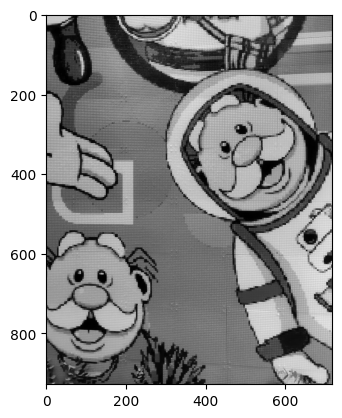

In [21]:
image=Image.open("img.jpg").convert("L")
image_numpy = np.asarray(image)
plt.imshow(image_numpy, cmap='gray')



Now, we are gonna compute the histogram of the image. Then, we are going to save it in the variable H_list-

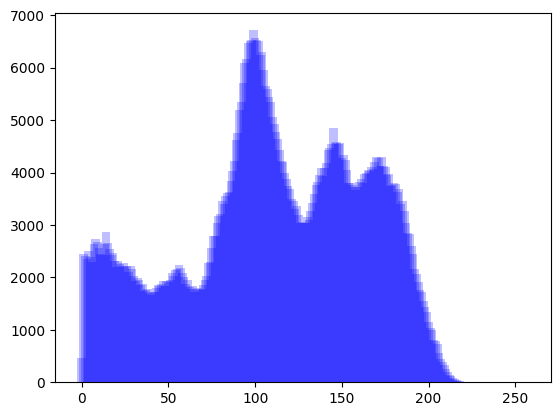

In [22]:
row, col = image_numpy.shape
    
y = np.zeros(256)
    
for i in range(0, row):
    for j in range(0, col):
        y[image_numpy[i, j]] += 1
    
# Plot the histogram
x = np.arange(0, 256)  
plt.bar(x, y, color='b', width=5, align='center', alpha=0.25)  
plt.show()  
    
h_list = y

We want to maximize the variance between the classes, and minimize the in-class variance.
A class is a set of pixels belonging to a region.



Also, to implement the method it is necessary to count pixels in the histogram

In [23]:
def countPixel(h):
    c = 0
    for i in range(0, len(h)):
        if h_list[i] > 0:
           c += h_list[i]
    return c

We need to calculate the probabilities and the number of pixels

In [24]:
cnt = countPixel(h_list)
probabilities = h_list/cnt

In order to implement the Otsu's Method, we need to define some functions to calculate the class probabilities (q(t)), the class mean (u(t))  and the individual class variance.

In [25]:
def weight_pix(s, e):
    w = 0
    
    for i in range(s, e):
        w += h_list[i]
    return w

def mean_pix(s, e):
    m = 0
    w = weight_pix(s, e)

    for i in range(s, e):
        m += h_list[i] * i
    return m / float(w)

def variance_pix(s, e):
    v = 0
    m = mean_pix(s, e)
    w = weight_pix(s, e)

    for i in range(s, e):
        v += ((i - m) ** 2) * h_list[i]/w
    return v

Finally, we are going to calculate the variance, weight and mean for the background and foreground class.

In [26]:


# Loop through each possible threshold value from 1 to 255 (as h has 256 bins, one for each intensity level)
for i in range(1, len(h_list)):

    # Compute the variance, probabilities, and mean for the "background" class
    v_back = variance_pix(0, i)
    w_back = weight_pix(0, i) / float(cnt)
    m_back = mean_pix(0, i)
    
    # Compute the variance, probabilities, and mean for the "foreground" class 
    v_fore = variance_pix(i, len(h_list))
    w_fore = weight_pix(i, len(h_list)) / float(cnt)
    m_fore = mean_pix(i, len(h_list))
   
    # Compute within-class variance (within_variance) 
    within_variance = w_back * (v_back) + w_fore * (v_fore)
    
    # Compute between-class variance (between_variance) 
    between_variance = w_back * w_fore * (m_back - m_fore)**2
        
          
    if not math.isnan(within_variance):
        threshold_values[i] = within_variance

    if not math.isnan(between_variance):
        threshold_values_between[i] = between_variance

/var/folders/h4/v6kv36fs44lg2yrrlf2z2jyr0000gn/T/ipykernel_22949/773017151.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return m / float(w)


Then, we are going to select the threshold which minimize the within classes variance.

In [27]:
min_within_variance = min(threshold_values.values())
optimal_threshold = [k for k, v in threshold_values.items() if v == min_within_variance]
print('optimal threshold', optimal_threshold[0])
optim_threshold = optimal_threshold[0]



optimal threshold 110


Now, let´s calculate the optimal threshold that maximizes the between class variance:


In [28]:
max_within_variance_between = max(threshold_values_between.values())
optimal_threshold = [k for k, v in threshold_values_between.items() if v == max_within_variance_between]
print('optimal threshold', optimal_threshold[0])
optim_threshold_between = optimal_threshold[0]

optimal threshold 110


Finally, we are going to restore the picture using the calculated optimal threshold

In [29]:
row, col = image_numpy.shape 
y = np.zeros((row, col))
for i in range(0, row):
    for j in range(0, col):
        if image_numpy[i, j] >= optim_threshold:
            y[i, j] = 255
        else:
            y[i, j] = 0
result = y

We plot the result, and save the image for the future activities.

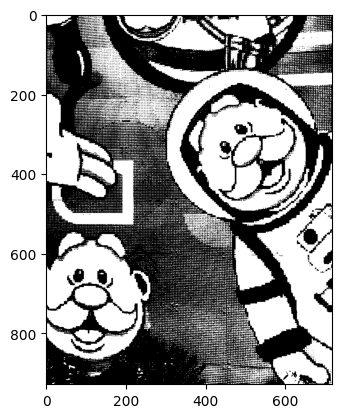

In [30]:
plt.imshow(result, cmap='gray')
plt.savefig("otsu.jpg")

## Extract the object boundaries using Laplacian (Zero-crossing)

In [31]:
import cv2 as cv
from scipy.signal import convolve2d

Compute gradient using sobel operator

In [32]:
gradHorizontal = cv.Sobel(result, cv.CV_64F, 1, 0, ksize=5)
gradVertical = cv.Sobel(result, cv.CV_64F, 0, 1, ksize=5)
gradBoth = cv.Sobel(result, cv.CV_64F, 1, 1, ksize=5)

gradEdgesDetected = np.abs(gradHorizontal) + np.abs(gradVertical)

We defined the kernel and threshold

In [33]:
kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) / 4.0
threshold = 2 * np.sqrt(np.var(gradEdgesDetected.flatten()))

laplacian = convolve2d(result, kernel, mode="same")

we saved the image to work with it in the point 5

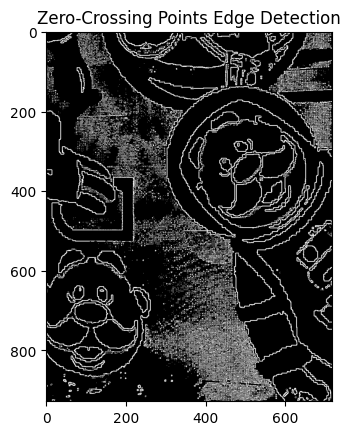

<Figure size 640x480 with 0 Axes>

In [34]:
zeroCrossingImg = np.abs(laplacian) < 0.05 * threshold
zeroCrossingAtSobel = np.multiply(zeroCrossingImg, gradEdgesDetected > threshold)

plt.imshow(zeroCrossingAtSobel, cmap="gray")
plt.title("Zero-Crossing Points Edge Detection")
plt.show()
plt.savefig("otsu_boundaries.jpg")

Then we plot the three images.

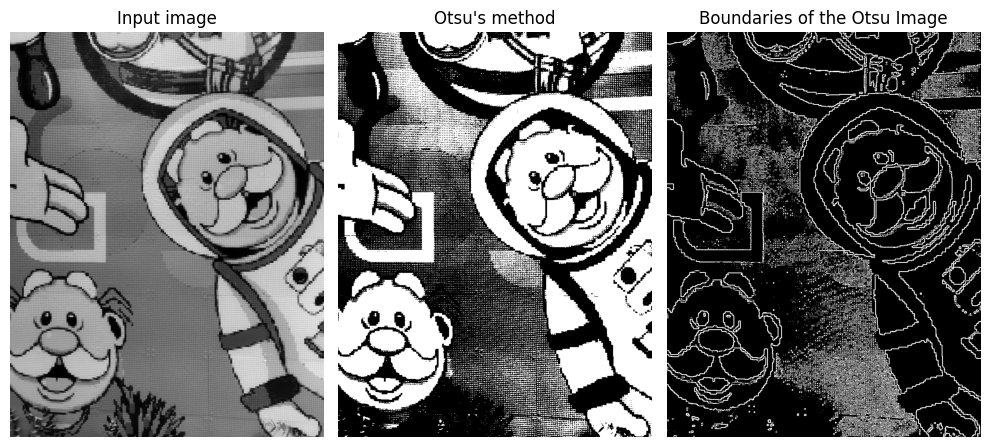

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[1].imshow(result, cmap='gray')
axs[1].set_title("Otsu's method")
axs[1].axis('off')  

axs[0].imshow(image_numpy, cmap='gray')
axs[0].set_title("Input image")
axs[0].axis('off')  

axs[2].imshow(zeroCrossingAtSobel, cmap='gray')
axs[2].set_title("Boundaries of the Otsu Image")
axs[2].axis('off')  

# Show the figure
plt.tight_layout()
plt.show()

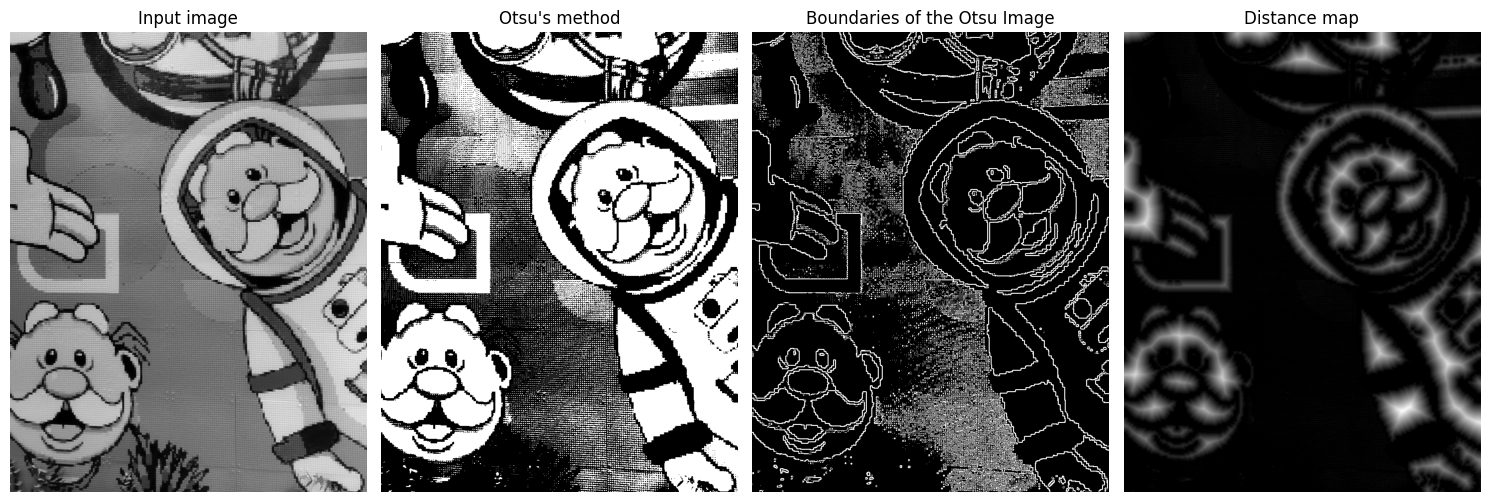

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage


# Step 1: Compute the distance map
distance_map = ndimage.distance_transform_edt(result)

# Step 2: Plot the input image, Otsu result, boundaries, and the distance map
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(image_numpy, cmap='gray')
axs[0].set_title("Input image")
axs[0].axis('off')

axs[1].imshow(result, cmap='gray')
axs[1].set_title("Otsu's method")
axs[1].axis('off')

axs[2].imshow(zeroCrossingAtSobel, cmap='gray')
axs[2].set_title("Boundaries of the Otsu Image")
axs[2].axis('off')

# Step 3: Plot the distance map
axs[3].imshow(distance_map, cmap='gray')
axs[3].set_title("Distance map")
axs[3].axis('off')

# Show the figure
plt.tight_layout()
plt.show()
